# Unsupervised Clustering
**Unsupervised** methods are the methods which allow us to pull out some structure automatically without having data labels.

## What is Clustering?
Clustering is a key data science method that summarizes data by grouping similar points together, rather than reducing dimensions like in dimensionality reduction. Each data point is assumed to come from a distribution, and clusters represent groups of similar points.  \
**Goal:**
1. Assign each point a cluster
2. Describe the clusters by, for example, drawing a shape around them
3. Answer the question: are two points in same cluster?

### Lower Dimension Example
Here's an example of clustering that we can easily visualize.

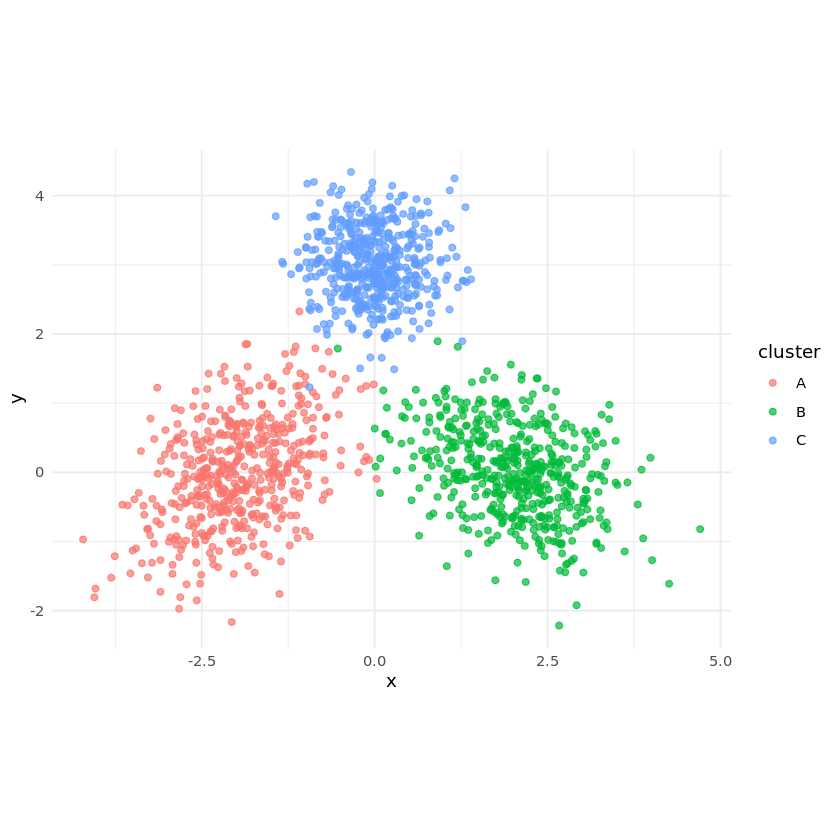

In [2]:
suppressPackageStartupMessages(library(tidyverse))

gaussian_clusters <- function(
  n = c(500, 500, 500),
  means = list(c(-2, 0), c(2, 0), c(0, 3)),
  covs = list(
    matrix(c(1.0,  0.5,
             0.5,  1.2)/2, 2, byrow = TRUE),
    matrix(c(1.2, -0.4,
            -0.4,  0.8)/2, 2, byrow = TRUE),
    matrix(c(0.5,  0.0,
             0.0,  0.5)/2, 2, byrow = TRUE)
  ),
  seed = 1L,
  labels = c("A","B","C")
) {
  stopifnot(length(n) == 3, length(means) == 3, length(covs) == 3)
  set.seed(seed)
  pieces <- Map(function(nn, mu, S) MASS::mvrnorm(nn, mu = mu, Sigma = S),
                n, means, covs)
  df <- as.data.frame(do.call(rbind, pieces))
  names(df) <- c("x", "y")
  df$cluster <- factor(rep(seq_along(n), n), labels = labels)
  df
}

# generate 3 Gaussian clusters in 2D and scatter plot
df <- gaussian_clusters()

ggplot(df, aes(x, y, color = cluster)) +
  geom_point(alpha = 0.7, size = 1.6) +
  coord_equal() +
  theme_minimal()

### Higher Dimension Example
This code creates synthetic data in 12 dimensions, generates three clusters (A, B, C) by drawing points from multivariate Gaussian distributions, then makes a scatterplot matrix of all 12 variables, colored by cluster. Then, we did PCA and plotted the first two components.

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



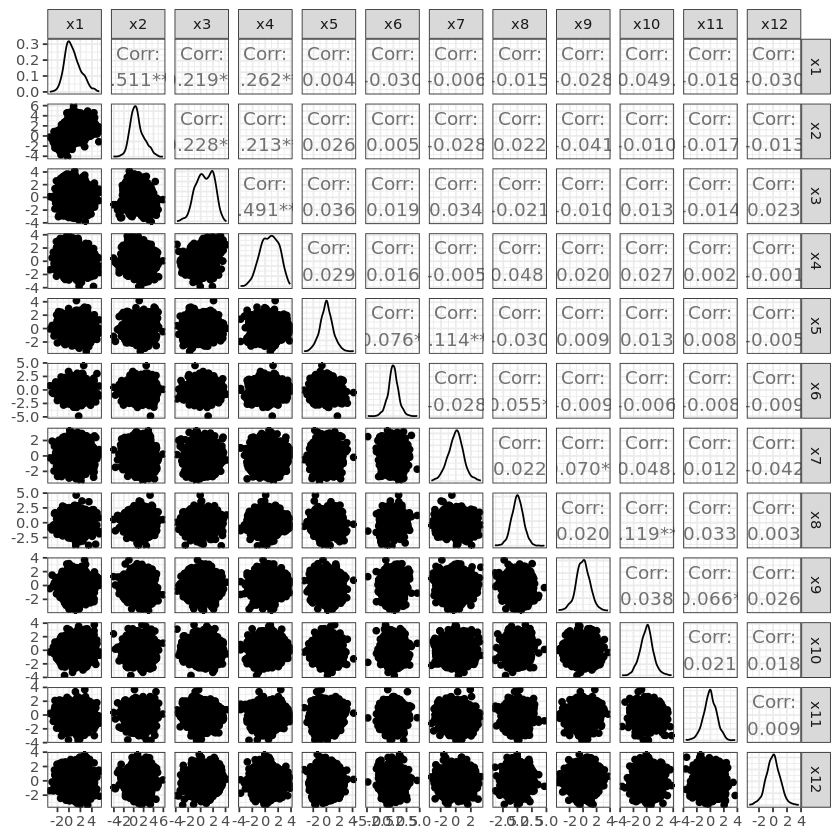

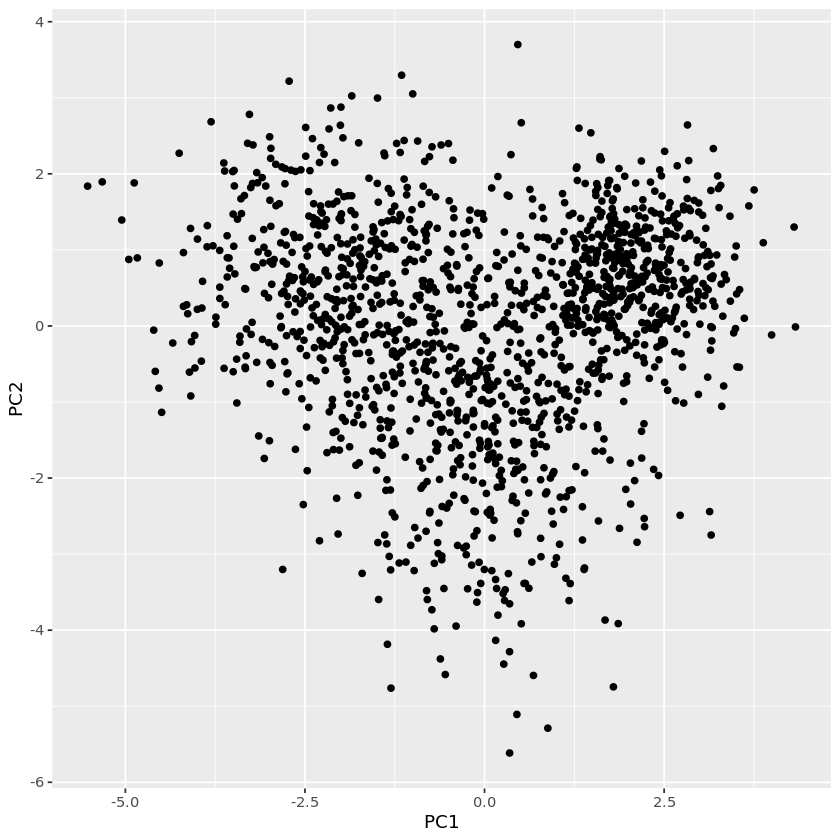

In [3]:
library(GGally)

gaussian_clusters_12d <- function(
  n = c(500, 500, 500),
  means = list(
    rep(0, 12),
    c(2, 2, rep(0, 10)),
    c(rep(0, 2), 2, 2, rep(0, 8))
  ),
  sigmas = c(1.0, 1.2, 0.7),
  rhos   = c(0.3, -0.2, 0.1),
  seed = 1L,
  labels = c("A", "B", "C")
) {
  stopifnot(length(n) == 3, length(means) == 3,
            length(sigmas) == 3, length(rhos) == 3)

  ar_cov <- function(p, sigma = 1, rho = 0.3) {
    i <- 0:(p - 1)
    Sigma <- outer(i, i, function(a, b) rho^abs(a - b))
    Sigma * (sigma^2)
  }

  p <- 12
  covs <- Map(function(s, r) ar_cov(p, sigma = s, rho = r), sigmas, rhos)

  set.seed(seed)
  pieces <- Map(function(nn, mu, S) MASS::mvrnorm(nn, mu = mu, Sigma = S),
                n, means, covs)

  df <- as.data.frame(do.call(rbind, pieces))
  names(df) <- paste0("x", seq_len(p))
  df$cluster <- factor(rep(seq_along(n), n), labels = labels)

  df
}

df <- gaussian_clusters_12d()

p <- GGally::ggpairs(df, columns = 1:12, progress = T) +
  theme_bw()

p

pr <- prcomp(df %>% select(-cluster))

ggplot(pr$x %>% as_tibble(), aes(PC1,PC2)) + geom_point()

## K-Means
K-means is to clustering what PCA is to dimensionality reduction. It's the simplest method that produces useful results.
1. Randomly assign points to clusters.
2. Compute cluster centroids (means).
3. Reassign points to the nearest centroid.
4. Recompute centroids.
5. Repeat until convergence (assignments no longer change).

### The Algorithm
Given a number of clusters to search for N: 
1.  Assign each point to a cluster N at random.
2.  Calculate the mean position of each cluster using the previous assignments.
3.  Loop through the points - assign each point to the cluster to whose center it is closest.
4.  Repeat this process until the centers stop moving around.

### Assumptions of K-Means
The assumption of this procedure are as follows:
1.  The data is in a vector space (why?)
2.  The clusters are characterized by their centers or centroids
3.  Cluster membership falls off at a similar rate from all centroids
4.  Clusters are about the same size
(These correspond roughly to the assumption that the clusters are spherical gaussians in N dimensions with the same or similar standard deviations).

A little bit like PCA - there really is no reason to ever expect these conditions to be true but somehow k-means works pretty well pretty often!

## K-Means Demo: Super Simple Example
This was in the part of the lecture where we were going through the `.html` example slides.
#### Step 0. Load the data.
I don't have the exact code the was used in lecture to generate this data, so here's the data generation and the plot of the data without labels.


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




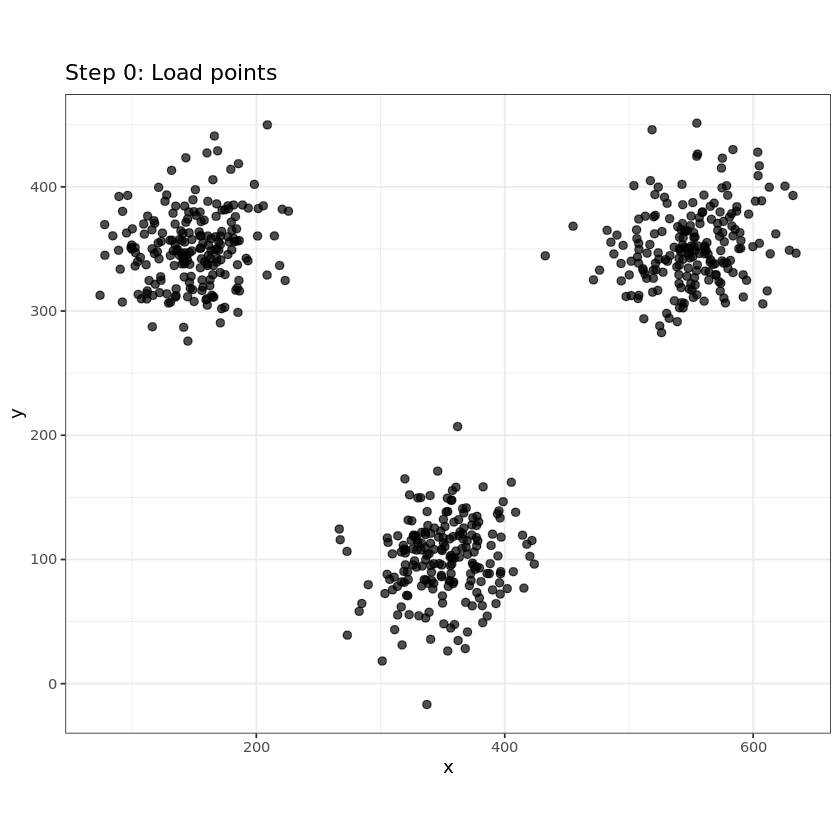

In [4]:
# Generating our data...
    # Normally, you'd be loading a data set in, but for the demo we'll generate it.
set.seed(123)

n <- 200

centers <- data.frame(
  cx = c(150, 350, 550),
  cy = c(350, 100, 350)
)

Sigma <- matrix(c(1000, 200, 
                  200, 1000), nrow = 2)  

library(MASS)

g1 <- as.data.frame(mvrnorm(n, mu = c(centers$cx[1], centers$cy[1]), Sigma))
g2 <- as.data.frame(mvrnorm(n, mu = c(centers$cx[2], centers$cy[2]), Sigma))
g3 <- as.data.frame(mvrnorm(n, mu = c(centers$cx[3], centers$cy[3]), Sigma))

df <- rbind(g1, g2, g3)
names(df) <- c("x", "y")

ggplot(df, aes(x, y)) +
  geom_point(size = 2, alpha = 0.7) +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 0: Load points")

#### Step 1. Assign points to clusters at random.

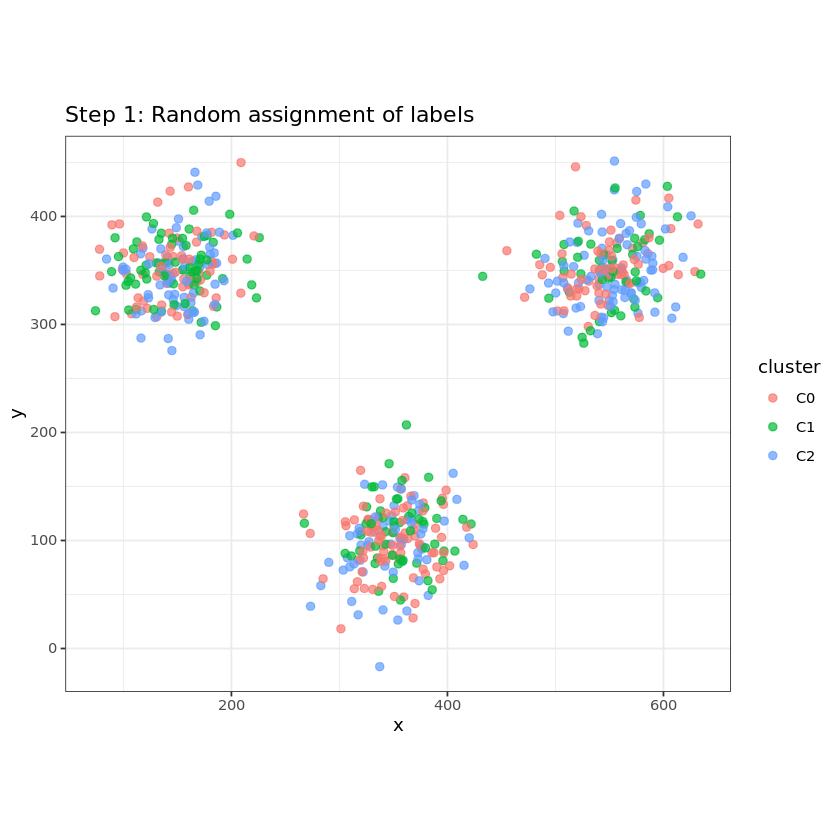

In [5]:
df$cluster <- sample(c("C0", "C1", "C2"), nrow(df), replace = TRUE)

library(ggplot2)
ggplot(df, aes(x, y, color = cluster)) +
  geom_point(size = 2, alpha = 0.7) +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 1: Random assignment of labels")

#### Step 2: Compute cluster means (centroids)
**The trick with k-means is an oscillation back and forth between which pieces of data we're treating as the authoritative piece of pieces of data describing the clusters, and which ones are the derived data.** We're going to say that a cluster is defined by the points inside the cluster. For each cluster that we have, we're going to calculate the center of the cluster by calculating the average position of all the points in the cluster. 

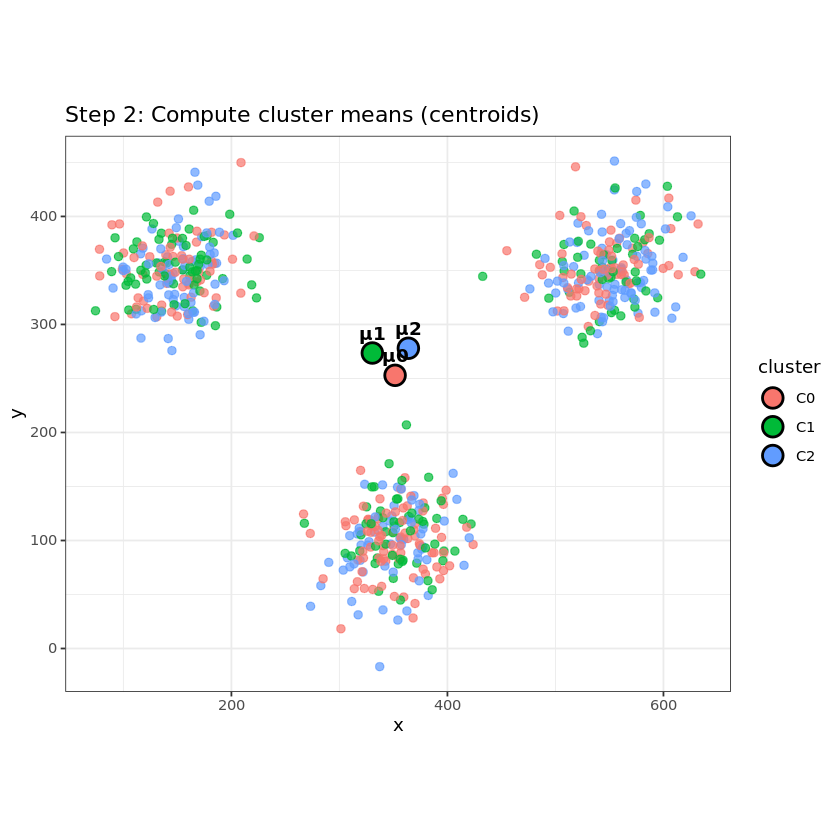

In [6]:
# compute centroids
centers_df <- df %>%
  group_by(cluster) %>%
  summarise(
    x = mean(x),
    y = mean(y),
    .groups = "drop"
  ) %>%
  arrange(cluster) %>%
  mutate(label = paste0("μ", row_number() - 1))

# plot with centroids
ggplot(df, aes(x, y, color = cluster)) +
  geom_point(size = 2, alpha = 0.7) +
  geom_point(data = centers_df, aes(x, y, fill = cluster),
             shape = 21, size = 5, color = "black", stroke = 1.2) +
  geom_text(data = centers_df, aes(x, y, label = label),
            vjust = -1, fontface = "bold", color = "black") +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 2: Compute cluster means (centroids)")

#### Step 3+: Iterate, reassign labels, recompute means
Now that we've calculated the centers, we're going to **treat the centers as the official representation of the cluster**, and we're going to ask ourselves the question:  
Given a set of centers, which points belong to that center?  
Answer: The points closest to the center belong to that center.

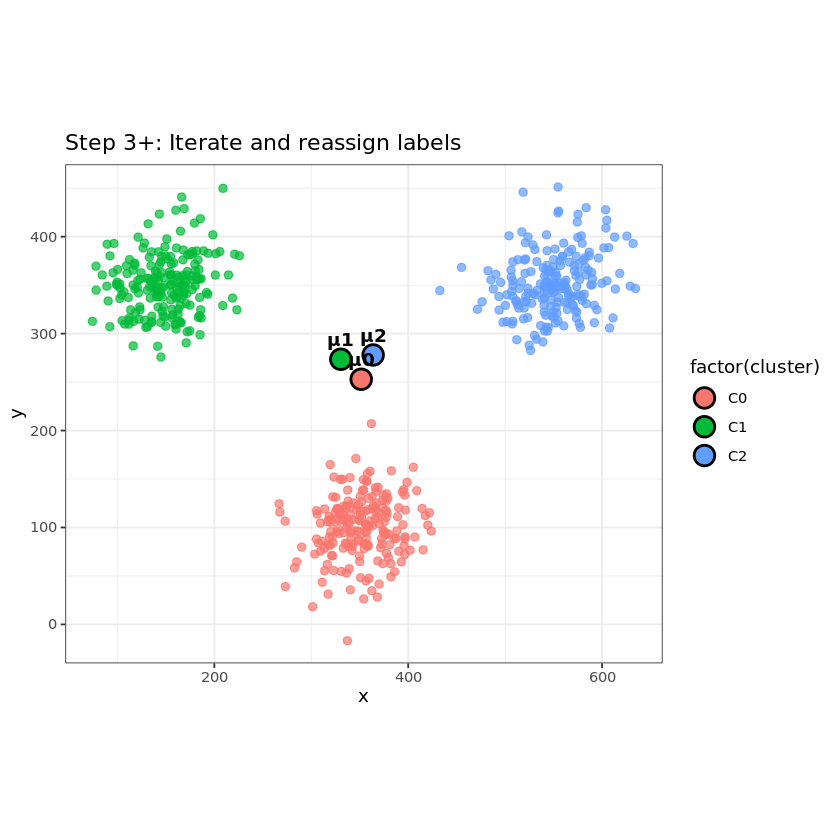

In [7]:
# function to assign each point to the nearest original centroid
assign_to_nearest <- function(df_points, centers) {
  df_points %>%
    rowwise() %>%
    mutate(
      cluster = centers$cluster[which.min(sqrt((x - centers$x)^2 + (y - centers$y)^2))]
    ) %>%
    ungroup()
}

# reassign clusters based on original centroids
df_new <- assign_to_nearest(df, centers_df)

# plot points with new clusters but original centroids
ggplot(df_new, aes(x, y, color = factor(cluster))) +
  geom_point(size = 2, alpha = 0.7) +
  geom_point(data = centers_df, aes(x, y, fill = factor(cluster)),
             shape = 21, size = 5, color = "black", stroke = 1.2) +
  geom_text(data = centers_df, aes(x, y, label = label),
            vjust = -1, fontface = "bold", color = "black") +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 3+: Iterate and reassign labels")

Then, we calculate the new means.

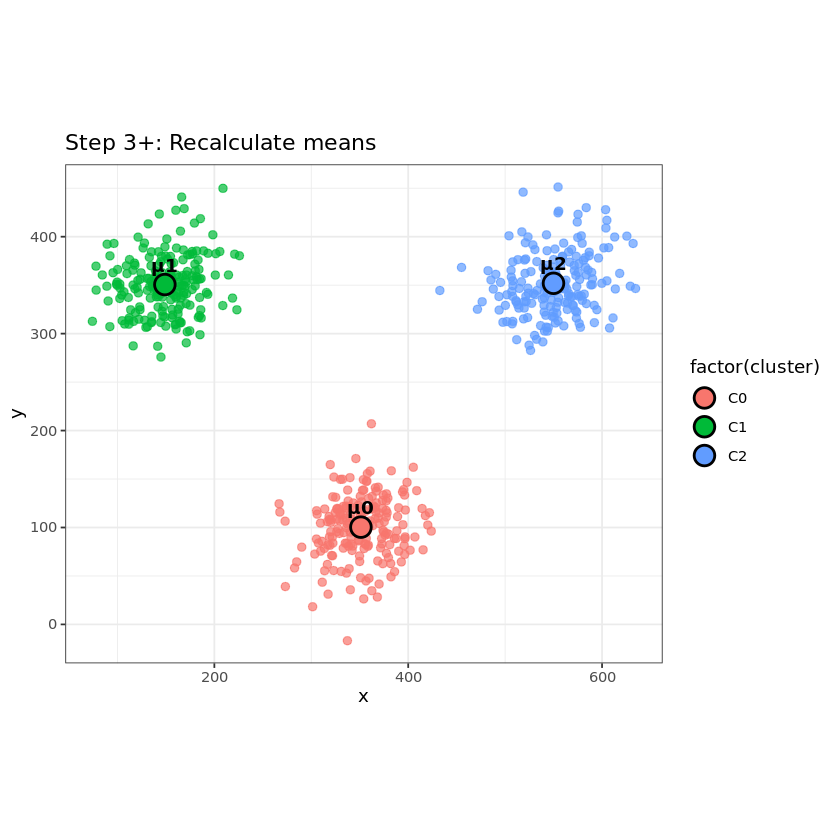

In [8]:
# compute new centroids based on reassigned clusters
new_centers_df <- df_new %>%
  group_by(cluster) %>%
  summarise(
    x = mean(x),
    y = mean(y),
    .groups = "drop"
  ) %>%
  arrange(cluster) %>%
  mutate(label = paste0("μ", row_number() - 1))

# plot updated clusters
ggplot(df_new, aes(x, y, color = factor(cluster))) +
  geom_point(size = 2, alpha = 0.7) +
  geom_point(data = new_centers_df, aes(x, y, fill = factor(cluster)),
             shape = 21, size = 5, color = "black", stroke = 1.2) +
  geom_text(data = new_centers_df, aes(x, y, label = label),
            vjust = -1, fontface = "bold", color = "black") +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 3+: Recalculate means")

Sometimes it doesn't converge on the first iteration, so you'll more than one iteration!

#### What did we accomplish?
We got:
1. **A label** for each data point, which corresponds to a cluster
2. **The mean** of each cluster

## Writing K-Means Ourselves!

#### Here's what was completed in class. Finishing and implementing this on data will be on Homework 8!

In [9]:
label_randomly <- function(n_points, n_clusters){
    sample((1:n_points %% n_clusters)+1, n_points, replace=F) #%% gives the remainder of points/clusters
}

get_cluster_means <- function(data, labels){
    data %>% mutate(label__ = labels) %>% group_by(labels__) %>%
    summarize(across(everything(),mean)) %>%
    mutate(label = label__) %>% arrange(label)
}

assign_cluster <- function(data, means){
    # slow way - for loop, fast way - matrix operations
    dii <- 1:nrow(data);
    cii <- 1:nrow(means);
    labels <- c()
    for(point_index in dii){
        smallest_dist <- Inf
        smallest_label <- NA
        for(clus in cii){
            point <- data[point_index,]
            clus <- means %>% select(-label__) %>% `[`(clus_index, )
            diff <- point - clus
            dist <- sum(diff*diff)
            if(dist < smallest_dist){
                smallest_dist <- dist;
                smallest_label <- means[clus_index,]$label__;
            }
        }
        labels <- c(labels, smallest_label)
    }        
    labels    
}

kmeans_done <- function(old_means, new_means, eps=1e-6){
    om <- old_means %>% as.matrix()
    nm <- new_means %>% as.matrix()

    m <- mean(sqrt(rowsums((om-nm)^2)))
    if(m<eps) T else F
}

mykmeans <- function(data, n_clusters, eps=1e-6){
    labels <- label_randomly(nrow(data), n_clusters)
    old_means <- get_cluster_means(data, labels);
    done <- F
    while (!done){
        labels <- assign_cluster(data, old_means)
        new_means <- get_cluster_means(data, labels)
        if kmeans_done(old_means, new_means){
            done <- T
        }
    }
    list(labels=labels, means=new_means)
}

ERROR: Error in parse(text = x, srcfile = src): <text>:49:12: unexpected symbol
48:         new_means <- get_cluster_means(data, labels)
49:         if kmeans_done
               ^


## K-Means Example: Voltage Traces
Here's data we've seen before - voltage traces! 

The first plot shows the true clusters, and the last plot shows the clusters separated by k-means, labeled by the true labels. As we can see, they were separated correctly, but not labeled correctly. 

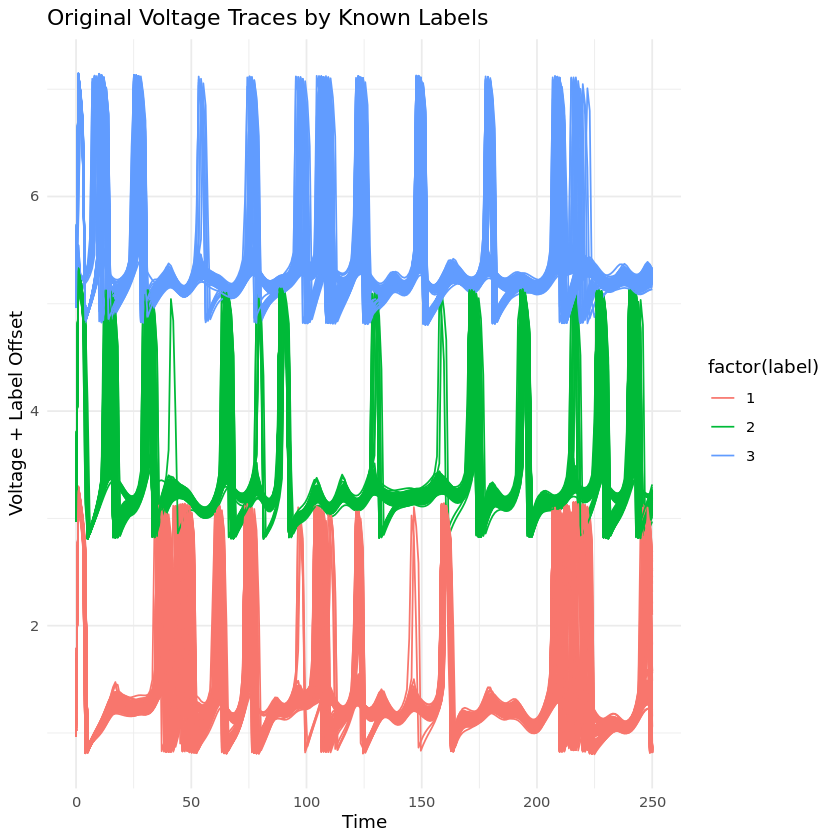

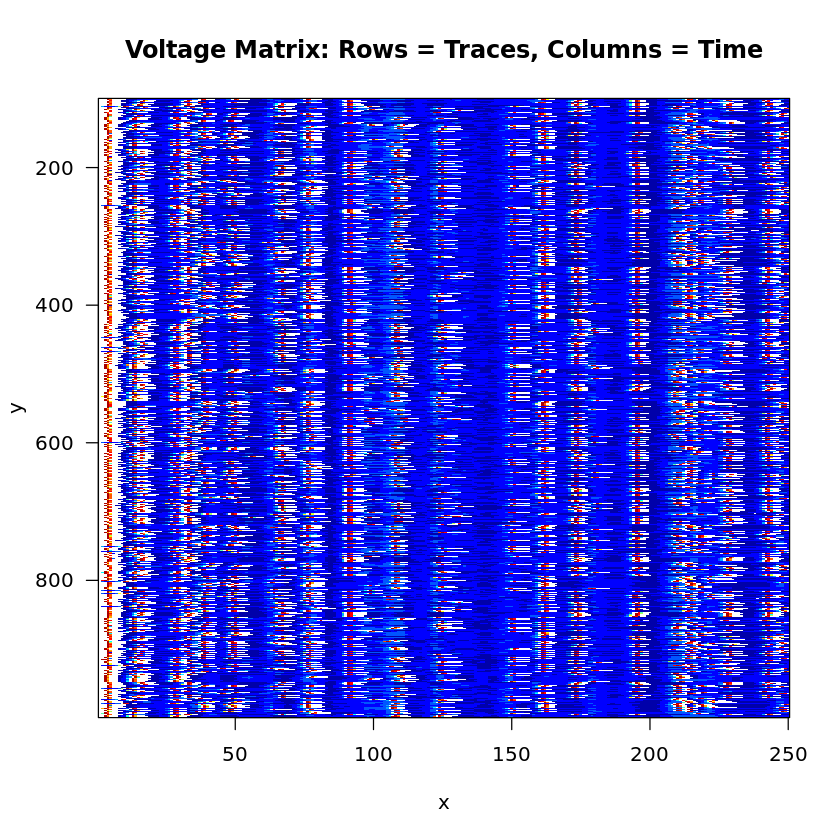

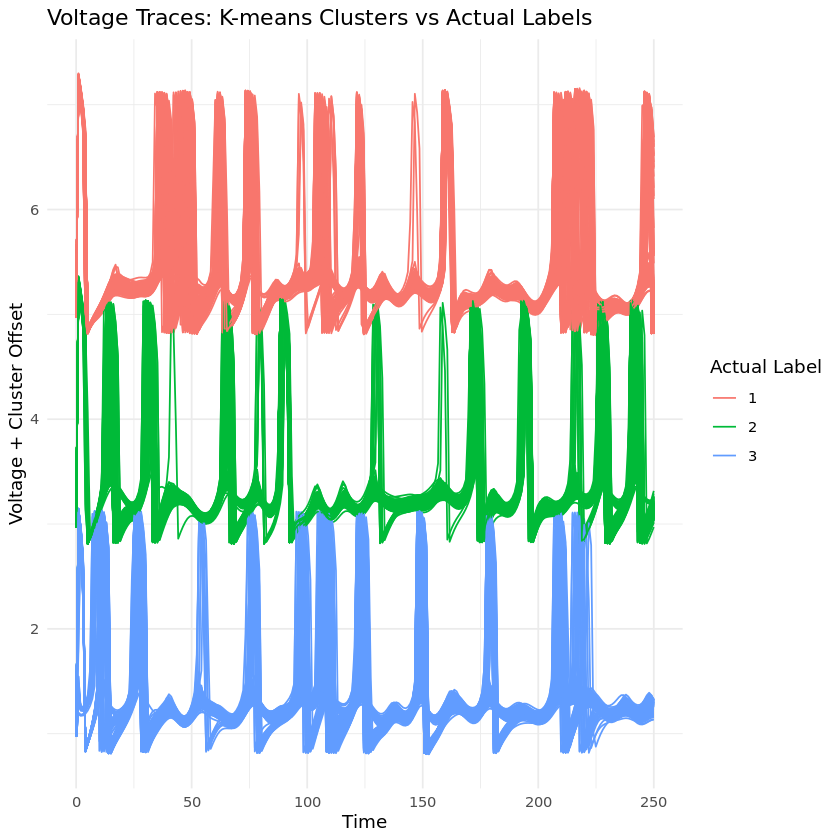

In [14]:
library(tidyverse)
library(matlab)

voltages <- suppressMessages(read_csv("voltages.csv"))

ggplot(voltages, aes(time, V + label*2)) + 
  geom_line(aes(color=factor(label),
                group=sprintf("%d:%d", trial, label))) +
  ggtitle("Original Voltage Traces by Known Labels") +
  ylab("Voltage + Label Offset") +
  xlab("Time") +
  theme_minimal()

voltages_wide <- voltages %>%
  arrange(time) %>%
  pivot_wider(id_cols = c("trial", "label"),
              names_from = "time",
              values_from = "V") %>%
  mutate(index = 1:nrow(.)) %>%
  arrange(runif(nrow(.)))

voltages_matrix <- voltages_wide %>% 
  dplyr::select(-trial, -label, -index) %>% 
  as.matrix()

imagesc(voltages_matrix)
title("Voltage Matrix: Rows = Traces, Columns = Time")

results <- kmeans(voltages_matrix, centers = 3)

voltages_ex <- voltages %>% 
  left_join(
    voltages_wide %>%
      mutate(cluster = results$cluster) %>%
      dplyr::select(trial, label, cluster),
    by = c("trial", "label")
  )

ggplot(voltages_ex, aes(time, V + cluster*2)) +
  geom_line(aes(group = sprintf("%d:%d", trial, label),
                color = factor(label))) +
  ggtitle("Voltage Traces: K-means Clusters vs Actual Labels") +
  ylab("Voltage + Cluster Offset") +
  xlab("Time") +
  theme_minimal() +
  labs(color = "Actual Label")

### Mutual Information

We have labels in this situation (1,2,3) and clusters, also indexed (1,2,3). K-means, even if it behaves perfectly, isn't guaranteed to give the cluster label 1 to the elements in group 1. For example, group 1 might be given cluster label 3, group 2 cluster label 1, and group 3 cluster label 2.

How do we compare labelings in general?

One strategy might be to calculate the centers of each labelled group and compare them to the cluster centers given by k-means:

`summarise()` has grouped output by 'time'. You can override using the
`.groups` argument.


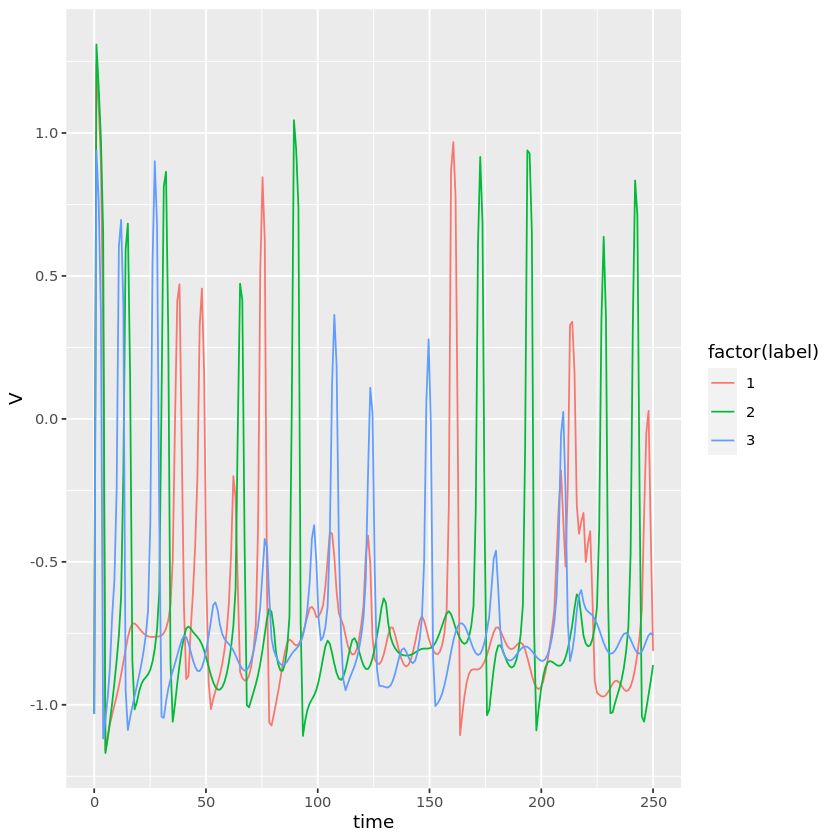

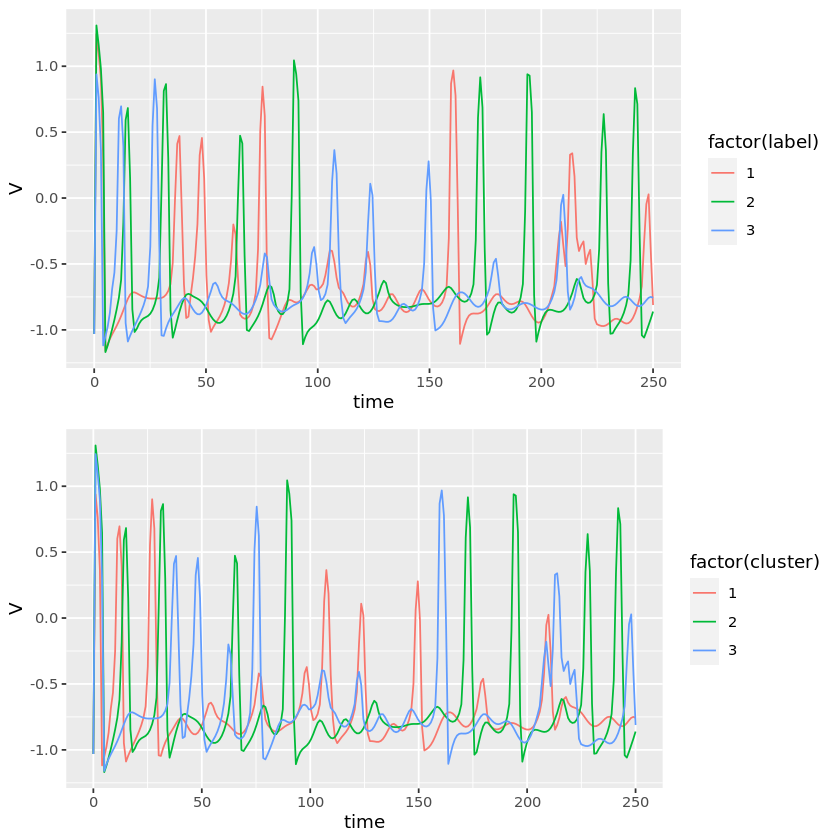

In [15]:
label_centers <- voltages %>%
    group_by(time, label) %>%
    summarize(V=mean(V)) %>%
    ungroup();

p1 <- ggplot(label_centers, aes(time,V)) + geom_line(aes(color=factor(label), group=label));
p1

cluster_centers <- results$centers %>% t() %>% as_tibble(rownames="time") %>%
    pivot_longer(cols=c(`1`,`2`,`3`)) %>% rename(cluster=name, V=value) %>%
    mutate(time=as.numeric(time)) %>% filter(complete.cases(.));


p2 <- ggplot(cluster_centers, aes(time, V)) + geom_line(aes(color=factor(cluster), group=cluster))

library(gridExtra);

grid.arrange(p1,p2,nrow=2);

However, given two labelings of equal length, there is something we can calculate to quantify how well the labels line up without explicitly knowing which cluster accounts for which label. This is particularly useful when the clustering isn't perfect: How can you tell which cluster really aligns with which label in such circumstances?

**Mutual information** is a measure of dependence: it tells you how much knowing one variable reduces uncertainty (or “surprise”) about the other.

First we need something called the **Shannon Information**.

### Shannon Information
Imagine you build a network of wireless telegraphs all over the world. Pretty soon people want to use them to communicate messages about increasingly complex things and in increasing volumes. The question is: how much information can such a channel actually transmit?  

Claude Shannon figured out a way to calculate such a thing.  

We first have to decide what we are transmitting. There are limits to how much you can transmit over a wire because of noise, so you choose a set of discrete symbols and a rate which ensures you almost always succeed in transmitting the signal. Then you calculate the Shannon Information for a sequence of such symbols like this:

In [17]:
shannon <- function(sequence){
  tbl <- (table(sequence)/length(sequence)) %>% as.numeric();
  -sum(tbl*log2(tbl))
}

mutinf <- function(a,b){
    sa <- shannon(a);
    sb <- shannon(b);
    sab <- shannon(sprintf("%d:%d", a, b));
    sa + sb - sab;
}

Note that when `a` and `b` are identical then the above is just `sa + sa - sa` and consequently the mutual information (MI) is equal to the entropy of `a` or `b`. We can thus normalize our MI for interpretability:

In [18]:
normalized_mutinf <- function(a,b){
    2*mutinf(a,b)/(shannon(a)+shannon(b));
}

This varies between 0 and 1 and returns 1 only when our two cluster labelings are identical.

In [19]:
normalized_mutinf(results$cluster, voltages_wide$label);

[1] 1

To compare two clusterings, you can use the normalized mutual information.

In [20]:
randomized <- results$cluster %>% sample(length(results$cluster))
normalized_mutinf(randomized, sample(voltages_wide$label))

[1] 0.006950124

This is a simulation to see how MI decreases as you randomly shuffle labels, showing how much “information” remains after progressively corrupting the label assignments.

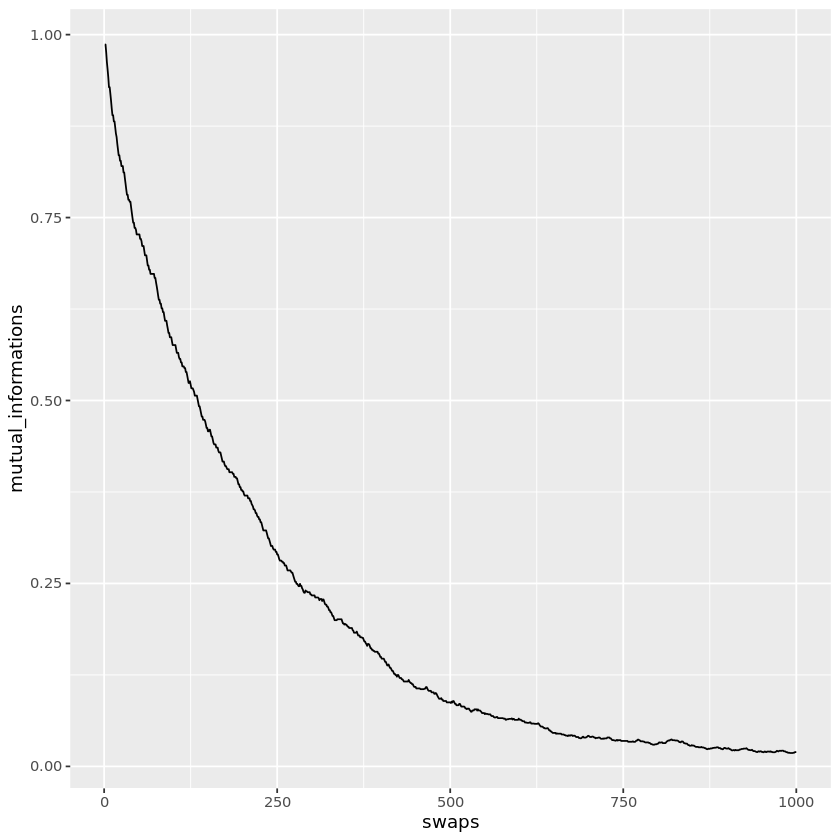

In [21]:
swaps <- seq(1000);
mutual_informations <- c()
cc <- voltages_wide$label;
for(i in swaps){
  indices <- sample(seq(length(cc)), 2, replace=F);
  tmp <- cc[[indices[[1]]]];
  cc[[indices[[1]]]] <- cc[[indices[[2]]]];
  cc[[indices[[2]]]] <- tmp;
  mutual_informations <- c(mutual_informations, normalized_mutinf(voltages_wide$label, cc))
}
df <- tibble(swaps=swaps, mutual_informations=mutual_informations);
ggplot(df, aes(swaps, mutual_informations)) + geom_line();

## Beyond K-Means
We'd like to point you to the documentation from scikit-learn's clustering module.

From a user's point of view this table does a good job of giving you an intuition about what clustering algorithms are good for and how they fail in particular situations.

![](sphx_glr_plot_cluster_comparison_001.png)

Just like with dimensionality reduction, there is a relationship between the methods you use and the assumptions you make about your data's mathematical structure.

**K-means assumes you have vectorial data** which is furthermore **distributed into uniformly shaped Gaussian of about the same size and shape**. It also assumes that an element is either in a cluster or not - so the probabilistic nature of the Gaussian is suppressed in favor of simplicity.

If we relax that last assumption we get fuzzy-k-means. In this algorithm each entity is only assigned a probability of being in a cluster based on its distance from the center. Fuzzy-k-means works well when your data is distributed in concentric clusters by may have outliers that you want to "automatically ignore".